**The Sparks Foundation**

Graduate Rotational Internship Program

Data Science & Business Analytics

Task :- 07

 **Stock Market Prediction using
Numerical and Textual Analysis** 

Author : S Bharadwaj

Download historical stock prices from [ finance.yahoo.com](https://)

Download textual (news) data from https://bit.ly/36fFPI6

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# reading the datasets into pandas
stock_price = pd.read_csv('BSESN.csv')

In [3]:
stock_headlines = pd.read_csv('india-news-headlines (1).csv')

In [4]:
len(stock_price), len(stock_headlines)

(252, 3424067)

In [5]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

**Stock Prices**

In [6]:
#dropping any null entries in our data
stock_price.dropna(axis=0, inplace=True)

In [7]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-08-19,115.707497,115.982498,117.162498,115.610001,145538000
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600
...,...,...,...,...,...
2021-08-12,148.889999,146.190002,149.050003,145.839996,72282600
2021-08-13,149.100006,148.970001,149.440002,148.270004,59318800
2021-08-16,151.119995,148.539993,151.190002,146.470001,103296000


**Stock Headlines**

In [8]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


**Combining both Prices and Headlines**

In [9]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-08-19,115.707497,115.982498,117.162498,115.610001,145538000.0,Rough diamond import decline 82% in April-July...
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200.0,"Stay away from water bodies: DDMA,Main accused..."
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800.0,Nothing is impossible in life because impossib...
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600.0,Sonali Bendre looks like true 'Mumbai chi mulg...
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600.0,Every thought if cats love you less than dogs ...
...,...,...,...,...,...,...
2020-12-24,131.970001,131.320007,133.460007,131.100006,54930100.0,How to set the mood for sex during cold winter...
2020-12-28,136.690002,133.990005,137.339996,133.509995,124486200.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,134.869995,138.050003,138.789993,134.339996,121047300.0,Man recovers charred remains of 'thief' from h...
2020-12-30,133.720001,135.580002,135.990005,133.399994,96452100.0,Numerology Readings 30 December 2020: Predicti...


In [10]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-08-19,115.707497,115.982498,117.162498,115.610001,145538000.0,Rough diamond import decline 82% in April-July...,,,,
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200.0,"Stay away from water bodies: DDMA,Main accused...",,,,
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800.0,Nothing is impossible in life because impossib...,,,,
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600.0,Sonali Bendre looks like true 'Mumbai chi mulg...,,,,
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600.0,Every thought if cats love you less than dogs ...,,,,


In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-08-19,115.707497,115.982498,117.162498,115.610001,145538000.0,Rough diamond import decline 82% in April-July...,-0.9998,0.126,0.807,0.067
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200.0,"Stay away from water bodies: DDMA,Main accused...",-0.9995,0.100,0.835,0.065
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800.0,Nothing is impossible in life because impossib...,-0.9996,0.118,0.803,0.079
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600.0,Sonali Bendre looks like true 'Mumbai chi mulg...,-0.9996,0.127,0.787,0.086
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600.0,Every thought if cats love you less than dogs ...,-0.9996,0.106,0.833,0.061


In [12]:
# dropping unwanted 'headline_text' and rearranging columns
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-08-19,115.707497,-0.9998,0.126,0.807,0.067,115.982498,117.162498,115.610001,145538000.0
2020-08-20,118.275002,-0.9995,0.100,0.835,0.065,115.750000,118.392502,115.732498,126907200.0
2020-08-21,124.370003,-0.9996,0.118,0.803,0.079,119.262497,124.867500,119.250000,338054800.0
2020-08-24,125.857498,-0.9996,0.127,0.787,0.086,128.697495,128.785004,123.937500,345937600.0
2020-08-25,124.824997,-0.9996,0.106,0.833,0.061,124.697502,125.180000,123.052498,211495600.0


**Feature engineering of the Combined Data**

In [13]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [14]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,9.400000e+01
mean,119.468563,-0.978378,0.127266,0.795787,0.076979,119.665053,121.281569,117.698138,1.396279e+08
std,6.787323,0.206019,0.017595,0.024256,0.011419,6.985640,6.750994,6.806737,6.028254e+07
min,106.839996,-0.999900,0.080000,0.743000,0.044000,104.540001,110.190002,103.099998,4.669130e+07
25%,115.057503,-0.999800,0.117250,0.781250,0.071000,115.095003,116.575003,113.047499,9.655132e+07
50%,118.457501,-0.999800,0.127500,0.792000,0.077000,118.470001,119.649997,116.444999,1.254366e+08
75%,123.622500,-0.999600,0.138000,0.809250,0.083000,124.134996,125.130001,121.535000,1.665631e+08
max,136.690002,0.997800,0.169000,0.857000,0.126000,138.050003,138.789993,134.339996,3.459376e+08


In [15]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2020-08-19 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     94 non-null     float64
 1   compound  94 non-null     float64
 2   negative  94 non-null     float64
 3   neutral   94 non-null     float64
 4   positive  94 non-null     float64
 5   Open      94 non-null     float64
 6   High      94 non-null     float64
 7   Low       94 non-null     float64
 8   Volume    94 non-null     float64
dtypes: float64(9)
memory usage: 7.3 KB


**Stock Data Analysis**

Text(0, 0.5, 'Close Price (INR)')

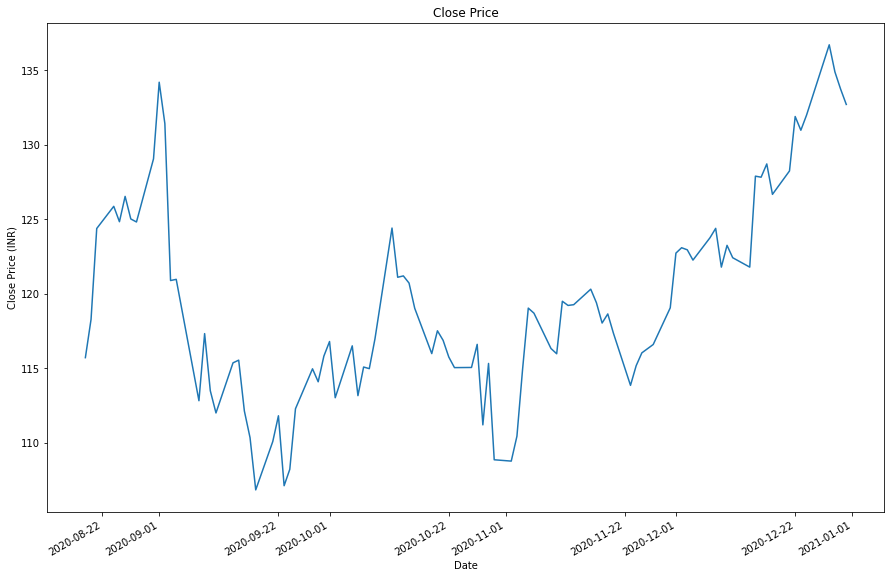

In [16]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [17]:

# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-27,122.938214,-0.999643,0.124143,0.802286,0.073571,122.530356,124.123572,120.928213,2.123583e+08
2020-08-28,124.238215,-0.999600,0.122714,0.801286,0.076143,123.963213,125.449286,122.209284,2.183714e+08
2020-08-31,125.776071,-0.999657,0.130143,0.790714,0.079286,125.653214,127.250357,123.676070,2.324851e+08
2020-09-01,127.177498,-0.999686,0.132571,0.787857,0.079714,127.581428,128.669286,125.287499,2.058984e+08


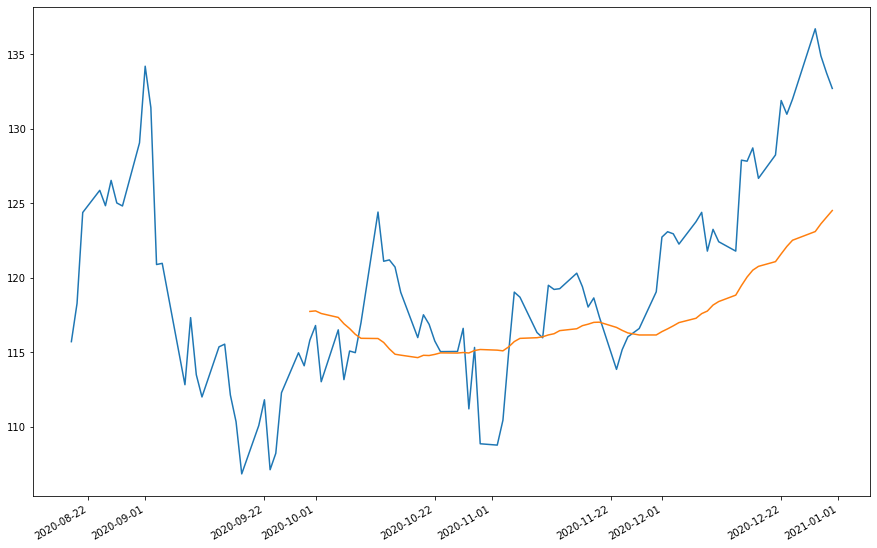

In [18]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [19]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-08-19,115.707497,-0.9998,0.126,0.807,0.067,115.982498,117.162498,115.610001,145538000.0
2020-08-20,118.275002,-0.9995,0.100,0.835,0.065,115.750000,118.392502,115.732498,126907200.0
2020-08-21,124.370003,-0.9996,0.118,0.803,0.079,119.262497,124.867500,119.250000,338054800.0
2020-08-24,125.857498,-0.9996,0.127,0.787,0.086,128.697495,128.785004,123.937500,345937600.0
2020-08-25,124.824997,-0.9996,0.106,0.833,0.061,124.697502,125.180000,123.052498,211495600.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,131.970001,-0.9966,0.080,0.857,0.063,131.320007,133.460007,131.100006,54930100.0
2020-12-28,136.690002,-0.9997,0.125,0.792,0.083,133.990005,137.339996,133.509995,124486200.0
2020-12-29,134.869995,-0.9997,0.134,0.777,0.089,138.050003,138.789993,134.339996,121047300.0
2020-12-30,133.720001,-0.9997,0.122,0.802,0.076,135.580002,135.990005,133.399994,96452100.0


**DATA FOR MODELLING**

In [20]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 74
Number of records in Test Data: 20


In [21]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2020-08-20    118.275002
2020-08-21    124.370003
2020-08-24    125.857498
2020-08-25    124.824997
2020-08-26    126.522499
                 ...    
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
2020-12-30    133.720001
2020-12-31    132.690002
Name: Close, Length: 93, dtype: float64

In [22]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2020-08-20,118.275002,124.370003,-0.9995,-0.9996,126907200.0,115.750000,118.392502,115.732498
2020-08-21,124.370003,125.857498,-0.9996,-0.9996,338054800.0,119.262497,124.867500,119.250000
2020-08-24,125.857498,124.824997,-0.9996,-0.9996,345937600.0,128.697495,128.785004,123.937500
2020-08-25,124.824997,126.522499,-0.9996,-0.9999,211495600.0,124.697502,125.180000,123.052498
2020-08-26,126.522499,125.010002,-0.9999,-0.9995,163022400.0,126.180000,126.992500,125.082497
2020-08-27,125.010002,124.807503,-0.9995,-0.9995,155552400.0,127.142502,127.485001,123.832497
2020-08-28,124.807503,129.039993,-0.9995,-0.9999,187630000.0,126.012497,126.442497,124.577499
2020-08-31,129.039993,134.179993,-0.9999,-0.9998,225702700.0,127.580002,131.000000,126.000000
2020-09-01,134.179993,131.399994,-0.9998,-0.9995,151948100.0,132.759995,134.800003,130.529999
2020-09-02,131.399994,120.879997,-0.9995,-0.9999,200119000.0,137.589996,137.979996,127.000000


In [23]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2020-08-20    124.370003
2020-08-21    125.857498
2020-08-24    124.824997
2020-08-25    126.522499
2020-08-26    125.010002
                 ...    
2020-12-23    131.970001
2020-12-24    136.690002
2020-12-28    134.869995
2020-12-29    133.720001
2020-12-30    132.690002
Name: close_price_shifted, Length: 92, dtype: float64

In [24]:

# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2020-08-20,118.275002,-0.9995,-0.9996,126907200.0,115.750000,118.392502,115.732498
2020-08-21,124.370003,-0.9996,-0.9996,338054800.0,119.262497,124.867500,119.250000
2020-08-24,125.857498,-0.9996,-0.9996,345937600.0,128.697495,128.785004,123.937500
2020-08-25,124.824997,-0.9996,-0.9999,211495600.0,124.697502,125.180000,123.052498
2020-08-26,126.522499,-0.9999,-0.9995,163022400.0,126.180000,126.992500,125.082497
...,...,...,...,...,...,...,...
2020-12-23,130.960007,-0.9995,-0.9966,88223700.0,132.160004,132.429993,130.779999
2020-12-24,131.970001,-0.9966,-0.9997,54930100.0,131.320007,133.460007,131.100006
2020-12-28,136.690002,-0.9997,-0.9997,124486200.0,133.990005,137.339996,133.509995
2020-12-29,134.869995,-0.9997,-0.9997,121047300.0,138.050003,138.789993,134.339996


In [25]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-2.33835598e-01, -9.99599539e-01, -9.99699655e-01,
         -4.63880422e-01, -3.30946086e-01, -4.26398421e-01,
         -1.91261152e-01],
        [ 1.74539596e-01, -9.99699655e-01, -9.99699655e-01,
          9.47315639e-01, -1.21307364e-01,  2.63987845e-02,
          3.39310521e-02],
        [ 2.74204233e-01, -9.99699655e-01, -9.99699655e-01,
          1.00000000e+00,  4.41807971e-01,  3.00350199e-01,
          3.34027102e-01],
        [ 2.05024950e-01, -9.99699655e-01, -1.00000000e+00,
          1.01462574e-01,  2.03073697e-01,  4.82519383e-02,
          2.77368840e-01],
        [ 3.18760405e-01, -1.00000000e+00, -9.99599539e-01,
         -2.22506009e-01,  2.91554623e-01,  1.75000230e-01,
          4.07330372e-01],
        [ 2.17420593e-01, -9.99599539e-01, -9.99599539e-01,
         -2.72431439e-01,  3.49000278e-01,  2.09440870e-01,
          3.27304758e-01],
        [ 2.03852823e-01, -9.99599539e-01, -1.00000000e+00,
         -5.80421546e-02,  2.81557429e-01,  1.36538470e-01

**Data divided for training and test datasets**

In [26]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (74, 7) and y: (74, 1)
Number of rows and columns in Test set X: (17, 7) and y: (17, 1)


In [27]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (74, 7)
Shape of Test set X: (17, 7)


**Data Modelling**

In [28]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1